In [ ]:
!wget -N http://www.cs.cornell.edu/people/pabo/movie-review-data/review_polarity.tar.gz

--2021-05-18 21:48:29--  http://www.cs.cornell.edu/people/pabo/movie-review-data/review_polarity.tar.gz
Resolving www.cs.cornell.edu (www.cs.cornell.edu)... 132.236.207.36
Connecting to www.cs.cornell.edu (www.cs.cornell.edu)|132.236.207.36|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3127238 (3.0M) [application/x-gzip]
Saving to: ‘review_polarity.tar.gz’

review_polarity.tar 100%[===================>]   2.98M  6.07MB/s    in 0.5s    

2021-05-18 21:48:30 (6.07 MB/s) - ‘review_polarity.tar.gz’ saved [3127238/3127238]



In [ ]:
#Part 1 Import and parse the dataset

import tarfile 
review_polarity = tarfile.open('review_polarity.tar.gz')
review_polarity.extractall('./content/review_polarity.tar.gz')
review_polarity.close()


import os 
import glob 
negative_files = glob.glob(os.path.join(os.getcwd(),'./content/review_polarity.tar.gz/txt_sentoken/neg','*txt'))
positive_files = glob.glob(os.path.join(os.getcwd(),'./content/review_polarity.tar.gz/txt_sentoken/pos','*txt'))

#X_raw are the reviews   
#y values are the labels 
X_raw = []
y = []
#Put files for negative and positive reviews into X_raw 

for file_path in negative_files:
  with open(file_path) as data_input: 
    X_raw.append(data_input.read().split())

for file_path in positive_files: 
  with open(file_path) as data_input: 
    X_raw.append(data_input.read().split())

#Append the first thousand entries with the negative reviews (-1)
for i in range(0,1000): 
  y.append(-1)
#Append the second thousand entires with the positive reviews (1)
for i in range(1000,2000):
  y.append(1)







In [ ]:
#Part 2 Extracting features from data

import numpy as np

#Put the data from X_raw into the ordered vocabulary 
ordered_vocabulary = set()
for i, doc in enumerate(X_raw): 
  X_raw[i] = set(doc) 
  for word in X_raw[i]:
    ordered_vocabulary.add(word) #
 
#Create an array that is the size of X_raw by the size of ordered_vocabulary 
X = np.zeros((len(X_raw), len(ordered_vocabulary)))

ordered_vocabulary = list(ordered_vocabulary)
ordered_vocabulary.sort() #Turn ordered vocabulary into a sorted list 
#Populate this array
for index, doc in enumerate(X_raw): 
  for index2, word in enumerate(ordered_vocabulary):
    if word in doc:
            X[index][index2]=1

In [ ]:
#Create pseudo-input 

#Split data into train and test sets in 80/20 proportion
#balance number of positive and negatives and define X and y as matrices


X = np.insert(X,0,1,axis=1)#x0 is the pseudo input 1, the initial guess for the parameter vector 
X_train = np.concatenate((X[:800], X[1000:1800]), axis=0)
X_test = np.concatenate((X[800:1000], X[1800:2000]), axis=0)
Y_train = np.concatenate((y[:800], y[1000:1800]), axis=0)
Y_test = np.concatenate((y[800:1000], y[1800:2000]), axis=0)

print(len(X_train))
print(len(X_test))
print(len(Y_train))
print(len(Y_test))

1600
400
1600
400


In [ ]:
#Part 3 Learning Framework
import numpy as np
import math

class Classifier: 

  def __init__(self, weight = None, learning_rate=0.01,epoch =1000, reg_dampening =.001):
    self.weight = weight
    self.learning_rate = learning_rate
    self.epoch = epoch
    self.reg_dampening = reg_dampening
    

  #Predict 
  def predict(self,w,X): #The initial hyperplane is given by the function that takes the sign of the dot product of omega and X. 
    dot_product_list = []  
    for i in range(len(X)):
      dot_product = np.dot(X[i],w) 
      dot_product_list.append(dot_product)#append all results of iterative dot product 
    dot_product_list = np.array(dot_product_list)
    sign_of_dot_product = np.sign(dot_product_list) #sign function of the same dot product value 
    fx_evaluated = np.array([i for i in sign_of_dot_product]) # Initial hyperplane is the sign of dot product evaluated, which equals the predicted y labels. 
    return sign_of_dot_product #Predicted labels from model with arbitrary w values to be tuned later

  def dot_product_no_sign(self,w,X): #created to use in hinge_loss function as input for the given equation
    dot_product_list = []  
    for i in range(len(X)):
      dot_product = np.dot(X[i],w)
      dot_product_list.append(dot_product)
    fx_evaluated = np.array([i for i in dot_product_list]) 
    return fx_evaluated 

  def l_2Regularization(self, w): 
  #Regularization adds the normal of the parameter vector squared & a lambda value/2 to the model. 
    
    value1 = (self.reg_dampening/2) #lambda value/2
    value2 = (np.linalg.norm(w)) # the normal vector of w 
    value2squared= (value2)**2
    regularization = value1 * value2squared #entire regularization expression 

    return regularization
  def hinge_loss(self,X,y): #Function calculates the loss for our model. Taken together with l2reg
  #X = sample data 
  #y = label 
    predicted_y = self.dot_product_no_sign(self.weight, X)
    count = 0
    for i in range(len(X)): 
      element2= np.max([0,1- y[i] * predicted_y[i]])  #operation to maximize margin stored in one expression
      count += element2
    return count 
  def objective_function(self, X, y, w):
    reg = self.l_2Regularization(w) #positive attenuation parameter to keep it from dominating the function
    element2= self.hinge_loss(X,y)
    objective_function = reg + element2
    return objective_function #hinge loss and reg together in one expression
  

  def gradient_descent(self,X,y,w): #Doing the analytical equivalent of taking a derivative of the loss with respect to every w value iternatively. 
  #Xi is a vector-- the ith data point
  #yi is a scalar--the ith label
    self.X_train = X
    self.Y_train = y 
    self.weight = w
    lambda_w = self.reg_dampening * self.weight #created to use as variable in given operation
    count = 0 
    for i in range(len(X)):
      if y[i]* np.dot(w,X[i]) < 1: 
        count += -y[i]*X[i] #create a count for iterating through elements of both y and X given the condition in the given equation
    gradient = lambda_w + count #store gradient in a variable to use in next line, for the reevaluated weight 
    reevaluated_weight = w - self.learning_rate * gradient 
    return reevaluated_weight


  def fit(self,X,y): #Fit with respect to input data 
    self.weight = np.random.randn(len(X[0]))
    iter = 0 #
    best_loss = 0
    count = 0
    for i in range(self.epoch): #iterate through the number of specified epoch 
      if best_loss == 0: #model does not have a loss before beginning this iterative process, starting point for the following conditions 
        loss = self.objective_function(X, y, self.weight)
        self.weight = self.gradient_descent(X, y, self.weight)
        best_loss = self.objective_function(X, y, self.weight)
        iter += 1
      else:
        if loss > best_loss-0.001:  
          if iter < self.epoch: #prevent training for stopping too soon with respect to the epoch specified 
            loss = self.objective_function(X, y, self.weight)
            best_loss = loss #update best loss 
            self.weight = self.gradient_descent(X, y, self.weight) #update weight with respect to output of gradient descent operation
            loss = self.objective_function(X, y, self.weight) 
            count += 1
            iter += 1

          else:
            if count > 5: #if the weight is not changing significantly forfiver iterations then the training will stop 
              break 

        elif loss <= best_loss - 0.001:
          loss = self.objective_function(X, y, self.weight)
          best_loss = loss 
          self.weight = self.gradient_descent(X, y, self.weight)
          loss = self.objective_function(X, y, self.weight)
          iter += 1
      #if iter % 50 == 0:
        #print(f"iter: {iter}, weight: {self.weight}, loss: {loss}")
    return loss 
      
  def score(self,X,y): #Return accuracy with respect to input data 
    a = self.predict(self.weight,X).reshape(-1, 1) #store operation on X from predict method in variable
    y = y.reshape(-1, 1) #reshape y to be able to do np.sum with y and a together 
    accuracy = np.sum(a==y)/len(y) 
    return accuracy



In [ ]:
import numpy as np
model= Classifier()

model.fit(X_train,Y_train)
print(model.weight)


[-0.07237029  1.75167264 -1.48954642 ... -0.46809494  1.09483905
  1.49516098]


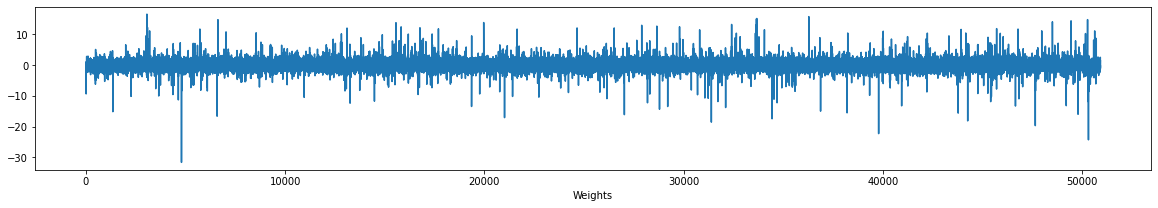

In [ ]:
#Visualization of the weights with respect to the 
import matplotlib.pyplot as plt
 
plt.figure(figsize=(20, 3))
plt.plot(model.weight[1:])
plt.xlabel("Value")
plt.xlabel("Weights")
plt.show()

In [ ]:
import matplotlib.pyplot as plt
list(ordered_vocabulary) 
print(len(model.weight))
print(len(ordered_vocabulary))
#the weight is the length of ordered vocabulary,so every element will represent the weight of one word
#assert (len(model.weight)-1) == len(ordered_vocabulary)

# Sort by absolute value
idx = np.argsort(np.abs(model.weight[1:]))#start from one because of pseudo input 
print("                Word   Weight  Occurences")
for i in idx[-20:]:   # Pick those with highest 'voting' values
  print("%20s   %.3f\t%i " % (ordered_vocabulary[i], model.weight[i+1], np.sum([ordered_vocabulary[i] in d for d in X_raw])))

50921
50920
                Word   Weight  Occurences
               quite   14.307	472 
        performances   14.730	368 
                   ?   -14.756	1228 
              reason   -14.781	360 
               looks   -14.797	363 
          ridiculous   -14.926	128 
                mess   -14.998	145 
               world   15.328	569 
                also   15.674	1070 
                both   16.733	620 
              stupid   -16.834	192 
                plot   -17.933	875 
            supposed   -18.129	255 
              boring   -18.336	217 
             nothing   -18.417	589 
                have   -19.103	1631 
       unfortunately   -19.377	329 
              script   -22.039	538 
               worst   -23.775	237 
                 bad   -29.080	760 


#Comments on the decision boundary and the weights 

Bad is the word with the highest weight out of the top twenty words with the most significant weighting in the model. It is of course a negative polarity, and it will be weighed more highly when it comes to the model classifying whether an unseen review is positive or negative. Other words that have negative connotations are also more heavily weighted in the model, such as boring, stupid, mess, unfortunately, and worst. On the other side of the decision boundary we have words that are more likely to be in positive reviews, as per how the model was trained, for example, perfect, and best. When I ran the model again the last time the results changed slightly but include words like "quite" and "performance" in the positive polarity, which normally would be used to talk positively about things, but aren't only positive. 

The model has done a pretty good job of classifying these positive and negative associations into positive and negative weights for classifying any future unseen reviews. 
One obvious shortcoming is how the model seems to be overlearning on "?", as I only split the data and did not use regular expressions to remove punctuation. It has determined that they show up more often in negative reviews, where it seems obvious such a factor is arbitrary and has no negative or positive significance. 



In [ ]:
#Part 4
#Return train set accuracy
reguliser_dampening= np.exp(np.linspace(np.log(0.0001), np.log(3), 10))
learning_rate=np.exp(np.linspace(np.log(0.1), np.log(3), 10))
parameter_distribution = {'learning_rate': np.exp(np.linspace(np.log(0.0001), np.log(3), 10)),'reguliser_dampening': np.exp(np.linspace(np.log(0.0001), np.log(3), 10))}


best_hyperparameters = None
print("Learning rate:\tReg.dampening:\tTraining set accuracy:")
learning_rate = parameter_distribution['learning_rate']
reguliser_dampening = parameter_distribution['reguliser_dampening']

for rd in reguliser_dampening: 
    for lr in learning_rate:
      model = Classifier(learning_rate = lr,reg_dampening=rd)
      model.fit(X_train, Y_train) #fit model with training set data 
      training_accuracy = model.score(X_train, Y_train)
      hyperparameters = {'learning_rate' : lr, 'reguliser_dampening' : rd}
      if best_hyperparameters is None or best_hyperparameters[1] < training_accuracy:
        best_hyperparameters = (hyperparameters, training_accuracy)
      print("%.5f\t\t%.5f\t\t%.1f%%" % (hyperparameters['learning_rate'], hyperparameters['reguliser_dampening'], 100*training_accuracy))

best_learning_rate = best_hyperparameters[0]['learning_rate']
best_reguliser_dampening = best_hyperparameters[0]['reguliser_dampening']
print("Best parameters: %.5f, %.5f" % (best_learning_rate, best_reguliser_dampening))


Learning rate:	Reg.dampening:	Training set accuracy:
0.00010		0.00010		96.5%
0.00031		0.00010		99.9%
0.00099		0.00010		100.0%
0.00311		0.00010		100.0%
0.00977		0.00010		100.0%
0.03071		0.00010		100.0%
0.09655		0.00010		100.0%
0.30353		0.00010		100.0%
0.95425		0.00010		100.0%
3.00000		0.00010		100.0%
0.00010		0.00031		96.4%
0.00031		0.00031		100.0%
0.00099		0.00031		100.0%
0.00311		0.00031		100.0%
0.00977		0.00031		100.0%
0.03071		0.00031		100.0%
0.09655		0.00031		100.0%
0.30353		0.00031		100.0%
0.95425		0.00031		100.0%
3.00000		0.00031		100.0%
0.00010		0.00099		96.5%
0.00031		0.00099		100.0%
0.00099		0.00099		100.0%
0.00311		0.00099		100.0%
0.00977		0.00099		100.0%
0.03071		0.00099		100.0%


In [ ]:
#Return test set accuracy for the model  
model=Classifier()
#Use best hyperparameters from the training in the previous cell
Classifier(learning_rate=0.00099,reg_dampening=.00010) #run classifier class with the best hyperparameters as per the results on the training set in the cell below 
#Fit model with test set data
model.fit(X_train, Y_train)
#Return test accuracy 
test_accuracy = model.score(X_test,Y_test)
print("Test set accuracy %.1f%%" % (100*test_accuracy))

Test set accuracy 87.8%


#Thoughts on design choices and learning experiences 
In part one, I decided to only split the data without  additional regular expressions or any other preprocessing measures, just to see how the model would perform and for part two, I merely made an array that would be the size of the list of documents x the size of the ordered vocabulary, and then populated it using a nested for loop. For part three, I decided to follow the steps outlined in the assignment description and try to make a function for every mathematical operation, storing variables and using methods as necessary. Additionally, I chose to make the weight into an array populated by random numbers instead of using zeros or ones, which I tried before and seemed to return bad results. Only after I made every equation in the description into a method, did I use these methods in the given structure (fit, predict, score), which later made part four easier in terms of quickly fitting the model and scoring its performance. 
In the training and scoring process, 1000 iterations seemed to reduce the loss pretty significantly as opposed to the initial loss which was well into the 10,000s. The model had a loss of 2.577 when the hyper parameters were set to a learning rate of .0031 and a reguliser dampening of .00010 for a training accuracy of 100%.
In terms of choosing the hyper parameters for fitting the model with the test data, I chose to go with the parameters that the model used for 100 % accuracy the first time it reached it with the training data set, which are the ones mentioned above. Initially I thought the model had reached 100 percent accuracy on the test set, but this way due to me also fitting the model with test data during this step, which obviously returned a perfect result as the model's accuracy was high, the loss was low, and it had been fit with the data that it would encounter in the test set already. 
When I rectified this mistake the accuracy on the test set went down to 87,6 with the aforementioned paramters. As an experiment, I played around with other learning rates, like .009, .0307 and the same lambda value as before, which pretty much returned the same result in terms of loss and accuracy.

I tried inputting a learning rate of .30353, to see if a higher learning rate would significantly lower the loss after enough iterations and return a higher accuracy, but that did not help. 
Running part four and fitting the model each time takes a lot of time, and running it one final time before turning it in slightly changed all the information I based my decision on in this report, which will account for any discrepancies. 

As a final experiment I used .95425 for the learning rate and .00031 as the lambda, which actually returned a slightly lower accuracy of 87.2 %. I also tried .95425 for the learning rate and a different lambda of .00099 to see if perhaps I needed to balance the equation with a different regularisation dampening, but this made the accuracy worse, returning 86.2 percent. 

The initial hyperparameters I used turned out to be the best.

All in all, I found that seeing the weights graphed helped to understand how the polarity was being assigned to certain words as the model was trained, and how a dataset with a decision boundary that could be represented linearly, and in our case with a hyperparameter in multidimensional space, could work pretty well for a small dataset like ours. 
I would say the accuracy hovering around 87.6 % is pretty good, given the initial decision to keep preprocessing to a minimum. 



